Alkım Ege Akarsu | 21901461 | EEE 485 | Term Project
# Classification of Diabetic and Non-Diabetic Individuals Based on Survey Data
# K-Nearest Neighbors
## Package Imports

In [1]:
import numpy as np  # For math operations
import pandas as pd  # For importing and handling datasets
import matplotlib.pyplot as plt  # For plotting
from mpl_toolkits.mplot3d import axes3d  # For 3D component of plotting

# Pandas options
pd.set_option('display.max_columns', None)

## Functions

In [2]:
# DATASET PREPARATION
def train_test_split(dataset, train_fraction):
    """Split the dataset into train and test sets

    Args:
        dataset (DataFrame): All available data points.
        Label and features as columns, Datapoints as rows.
        train_fraction (float): Fraction of data
        points to be added to the training set.

    Returns:
        DataFrame: Training dataset
        DataFrame: Test dataset
    """
    # Randomly sample for train
    train = dataset.sample(frac=train_fraction, axis="index")
    # Subtract train from original
    test = dataset.drop(index=train.index)
    # Reset indexes
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)

    return train, test


def mini_dataset(dataset, fraction):
    """Return a fraction of the dataset.

    Args:
        dataset (DataFrame): Original dataset. Has shape (n, p).
        fraction (double): Fraction of dataset to return.

    Returns:
        DataFrame: Smaller dataset. Has shape (n / fraction, p).
    """
    return dataset.sample(frac=fraction,
                          axis="index",
                          ignore_index=True)


def standardize(train, test):
    """Standardize X matrices of train and test splits. Uses the mean and
    standard deviation of the training set to standardize both training
    and test sets. This prevents data leakage between training and test sets.

    Args:
        train (DataFrame): Training set.
        test (DataFrame): Test set.

    Returns:
        DataFrame: Standardized training set
        DataFrame: Standardized test set
    """
    # Get mean and standard deviation
    mean = train.mean()
    std = train.std()
    # Get results
    train_result = (train - mean) / std
    test_result = (test - mean) / std

    return train_result, test_result


def range_scaling(train, test):
    """Scale X matrices of train and test splits. Uses the min and
    max values of the training set to scale both training
    and test sets. This prevents data leakage between training and test sets.

    Args:
        train (DataFrame): Training set.
        test (DataFrame): Test set.

    Returns:
        DataFrame: Standardized training set
        DataFrame: Standardized test set
    """
    # Get min and max values
    min_val = train.min()
    max_val = train.max()
    # Get results
    train_result = (train - min_val) / (max_val - min_val)
    test_result = (test - min_val) / (max_val - min_val)

    return train_result, test_result


# K-NEAREST NEIGHBORS
def get_minkowski_distance(X, row_index, p):
    """Calculate the minkowski distance between
    a point and every point in X. INCLUDES THE POINT ITSELF.

    Args:
        X (ndarray): Feature matrix. Has shape (n, p).
        row_index (int): Index of point in X.
        p (int): The power parameter

    Returns:
        ndarray: Distances between the given point and every point in X.
        Index [n] has the distance between the given point and point
        at index n in X. Has shape (n,).
    """
    # Get the point of interest
    point = X[row_index]

    # Calculate the Minkowski distance
    distances = np.sum(np.abs(X - point)**p, axis=1)**(1/p)

    return distances


def get_cosine_distance(X, row_index):
    """Calculate the cosine distance between
    a point and every point in X. INCLUDES THE POINT ITSELF.

    Args:
        X (ndarray): Feature matrix. Has shape (n, p).
        row_index (int): Index of point in X.

    Returns:
        ndarray: Distances between the given point and every point in X.
        Index [n] has the distance between the given point and point
        at index n in X. Has shape (n,).
    """
    # Get the point of interest
    point = X[row_index]

    # Normalize the vectors
    X_norm = np.linalg.norm(X, axis=1)
    point_norm = np.linalg.norm(point)

    # Calculate the cosine similarity
    cosine_similarities = np.dot(X, point) / (X_norm * point_norm)

    # Convert cosine similarities to cosine distances
    cosine_distances = 1 - cosine_similarities

    return cosine_distances


def get_chebyshev_distance(X, row_index):
    """Calculate the chebyshev distance between
    a point and every point in X. INCLUDES THE POINT ITSELF.

    Args:
        X (ndarray): Feature matrix. Has shape (n, p).
        row_index (int): Index of point in X.

    Returns:
        ndarray: Distances between the given point and every point in X.
        Index [n] has the distance between the given point and point
        at index n in X. Has shape (n,).
    """
    # Get the point of interest
    point = X[row_index]

    # Calculate the Chebyshev distance
    distances = np.max(np.abs(X - point), axis=1)

    return distances


def get_k_nearest_labels(X, y, k, get_distance, p_minkowski=None):
    """Get the labels of the k nearest neighbors of every point in X.

    Args:
        X (ndarray): Feature matrix. Has shape (n, p).
        y (ndarray): Labels. Has shape (n, 1).
        k (int): Number of nearest neighbors.
        get_distance (function): Distance function to be used.
        p_minkowski (optional(int)): Minkowski distance parameter.

    Returns:
        ndarray: Labels of the nearest neighbors. Has shape (n, k).
    """
    # Initialize an empty ndarray to store the labels of the k nearest neighbors
    nearest_labels = np.empty((X.shape[0], k))

    # Iterate over each point in X
    for i in range(X.shape[0]):
        # Print progress
        if i % 100 == 0:
            print(f"Point: {i}\n")
        
        # Calculate the distances from the point to all other points
        if p_minkowski == None:
            distances = get_distance(X, i)
        else:
            distances = get_distance(X, i, p_minkowski)

        # Get the indices of the k nearest NEIGHBORS
        nearest_indices = np.argsort(distances)[1 : k + 1]

        # Get the labels of the k nearest neighbors
        nearest_y = y[nearest_indices]

        # Store the labels in the ndarray
        nearest_labels[i, :] = nearest_y.ravel()

    return nearest_labels


def get_k_nearest_labels_point(X, y, k, row_index, get_distance, p_minkowski=None):
    """Get the labels of the k nearest neighbors of given row index.

    Args:
        X (ndarray): Feature matrix. Has shape (n, p).
        y (ndarray): Labels. Has shape (n, 1).
        k (int): Number of nearest neighbors.
        row_index (int): Index of point in X.
        get_distance (function): Distance function to be used.
        p_minkowski (optional(int)): Minkowski distance parameter.

    Returns:
        ndarray: Labels of the nearest neighbors. Has shape (k, 1).
    """
    # Calculate the distances from the point to all other points
    if p_minkowski == None:
        distances = get_distance(X, row_index)
    else:
        distances = get_distance(X, row_index, p_minkowski)

    # Get the indices of the k nearest neighbors
    nearest_indices = np.argsort(distances)[1 : k + 1]

    # Get the labels of the k nearest neighbors
    nearest_y = y[nearest_indices]

    # Return the labels
    return nearest_y.ravel()


def get_weights(y):
    """Determine the weights of each class in relation to their frequency.
    Class weights are inversely proportional to the frequency of each class.

    Args:
        y (ndarray): Labels. Has shape (n, 1).

    Returns:
        tuple(double, double): Weights of respective classes.
    """
    # Count the occurrence of each label
    counts = np.bincount(y.astype("int").flatten())

    # Get the total number of labels
    total = y.shape[0]

    # Determine the weights of each class in relation to their frequency
    weight_of_0 = total / counts[0]
    weight_of_1 = total / counts[1]

    return (weight_of_0, weight_of_1)


def get_k_value(X):
    """Returns the k value to be used for k-nearest neighbors.

    Args:
        X (ndarray): Feature matrix. Has shape (n, p).
    
    Returns:
        int: k value
    """
    # Optimal value of k is the square root of the number of points
    k_opt = np.sqrt(X.shape[0])
    # Return closest odd number
    lower = int(k_opt) - int(k_opt) % 2 + 1
    upper = lower + 2
    return lower if k_opt - lower < upper - k_opt else upper


def predict_from_same_set(X, y, k, weights, get_distance, weighted=True, p_minkowski=None):
    """Predict the class of every point (row) in X.

    Args:
        X (ndarray): Feature matrix. Has shape (n, p).
        y (ndarray): Labels. Has shape (n, 1).
        k (int): Number of nearest neighbors.
        weights (tuple(double, double)): Weights of respective classes.
        get_distance (function): Distance function to be used.
        weighted (bool): If True, use weighted voting.
        p_minkowski (optional(int)): Minkowski distance parameter.

    Returns:
        ndarray: Predicted labels. Has shape (n, 1).
    """
    # Get the labels of the k nearest neighbors for each point in X
    if p_minkowski == None:
        nearest_labels = get_k_nearest_labels(X, y, k, get_distance)
    else:
        nearest_labels = get_k_nearest_labels(X, y, k, get_distance, p_minkowski)

    # Initialize an empty ndarray to store the predicted labels
    predicted_labels = np.empty(X.shape[0], dtype=np.uint8)

    # Iterate over each point in X
    for i in range(X.shape[0]):
        # Get the labels of the k nearest neighbors for the point
        labels = nearest_labels[i, :]

        # Count the occurrence of each label
        counts = np.bincount(labels.astype("int"))
        
        # If weighted voting is enabled, multiply the counts by the weights
        if weighted:
            for j in range(counts.shape[0]):
                counts[j] *= weights[j]

        # Get the label with the highest occurrence
        predicted_label = np.argmax(counts)

        # Store the predicted label in the ndarray
        predicted_labels[i] = predicted_label

    return predicted_labels.reshape(-1, 1)


def predict_from_different_set(X_train, y_train, X_valid, y_valid, k, weights, get_distance, weighted=True, p_minkowski=None):
    """Predict the class of every point (row) in X_valid. Picks point from
    X_valid and puts it in X_train for prediction.

    Args:
        X_train (ndarray): Training feature matrix. Has shape (n, p).
        y_train (ndarray): Training labels. Has shape (n, 1).
        X_valid (ndarray): Validation feature matrix. Has shape (m, p).
        y_valid (ndarray): Validation labels. Has shape (m, 1).
        k (int): Number of nearest neighbors.
        weights (tuple(double, double)): Weights of respective classes.
        get_distance (function): Distance function to be used.
        weighted (bool, optional): If True, use weighted voting.
        p_minkowski (optional(int)): Minkowski distance parameter.
        
    Returns:
        ndarray: Predicted labels. Has shape (m, 1).
    """
    # Initialize an empty ndarray to store the predicted labels
    predicted_labels = np.empty(X_valid.shape[0], dtype=np.uint8)

    # Iterate over each point in X_valid
    for i in range(X_valid.shape[0]):
        
        # Append the point to the end of X_train
        X = np.vstack((X_train, X_valid[i, :]))
        y = np.vstack((y_train, y_valid[i, :]))

        # Get the labels of the k nearest neighbors for the point
        row_index = -1
        if p_minkowski == None:
            nearest_labels = get_k_nearest_labels_point(X, y, k, row_index, get_distance)
        else:
            nearest_labels = get_k_nearest_labels_point(X, y, k, row_index, get_distance, p_minkowski)

        # Count the occurrence of each label
        counts = np.bincount(nearest_labels.astype("int"))
        
        # If weighted voting is enabled, multiply the counts by the weights
        if weighted:
            for j in range(counts.shape[0]):
                counts[j] *= weights[j]

        # Get the label with the highest occurrence
        predicted_label = np.argmax(counts)

        # Store the predicted label in the ndarray
        predicted_labels[i] = predicted_label

    return predicted_labels.reshape(-1, 1)


# MODEL EVALUATION
def get_confusion_matrix(true, pred):
    """Calculate confusion matrix for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        ndarray: Confusion matrix
        TN FP
        FN TP
    """
    result = np.zeros((2, 2))

    for i in range(true.shape[0]):
        result[true[i][0]][pred[i][0]] += 1

    return result


def get_accuracy(true, pred):
    """Calculate accuracy for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: Accuracy value.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return (TP + TN) / (TP + TN + FP + FN)


def get_precision(true, pred):
    """Calculate precision for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: Precision value.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return TP / (TP + FP)


def get_recall(true, pred):
    """Calculate recall for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: Recall value.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return TP / (TP + FN)


def get_f1_score(true, pred):
    """Calculate F1 score for performance evaluation.

    Args:
        true (ndarray): Array of true labels. Has shape (t, 1).
        pred (ndarray): Array of predicted labels. Has shape (t, 1).

    Returns:
        double: F1 score.
    """
    TN, FP, FN, TP = get_confusion_matrix(true, pred).ravel()
    return (2 * TP) / ((2 * TP) + FP + FN)


# HYPERPARAMETER TUNING
def cross_validation(X_train, y_train, k, weights, get_distance, K, weighted=True, p_minkowski=None):
    """Evaluate model performance using K-fold cross-validation.

    Args:
        X_train (ndarray): Training feature matrix. Has shape (n, p).
        y_train (ndarray): Training labels. Has shape (n, 1).
        k (int): Number of nearest neighbors.
        weights (tuple(double, double)): Weights of respective classes.
        get_distance (function): Distance function to be used.
        K (int): Number of folds
        weighted (bool, optional): If True, use weighted voting.
        p_minkowski (optional(int)): Minkowski distance parameter.

    Returns:
        double: Mean F1 score of all K folds
    """
    # Initialize f1 score storage
    f1_scores = np.zeros(K)
    # Split dataset into k folds
    X_folds = np.array_split(X_train, K)
    y_folds = np.array_split(y_train, K)
    # Loop over folds
    for i in range(K):
        # Get validation set
        X_validation_set = X_folds[i]
        y_validation_set = y_folds[i]
        # Get training set (list comprehension ftw)
        X_training_set = np.concatenate([X_folds[j] for j in range(K) if j != i])
        y_training_set = np.concatenate([y_folds[j] for j in range(K) if j != i])
        # Validate model on validation set
        if p_minkowski is None:
            predictions = predict_from_different_set(X_training_set, y_training_set, X_validation_set, y_validation_set, k, weights, get_distance, weighted)
        else:
            predictions = predict_from_different_set(X_training_set, y_training_set, X_validation_set, y_validation_set, k, weights, get_distance, weighted, p_minkowski)
        f1_score = get_f1_score(y_validation_set, predictions)
        # Save F1 score
        f1_scores[i] = f1_score
    # Return average F1 score
    return f1_scores.mean()


def tune_minkowski(X_train, y_train, weights, K, p_values, k_values, weighted=True):
    """Try to find the best p and k values using grid search
    and K-fold cross validation.
    
    Args:
        X_train (ndarray): Training feature matrix. Has shape (n, p).
        y_train (ndarray): Training labels. Has shape (n, 1).
        weights (tuple(double, double)): Weights of respective classes.
        K (int): Number of folds
        p_values (ndarray of ints): List of p values to try.
        k_values (ndarray): List of k values to try.
        weighted (bool, optional): If True, use weighted voting.

    Returns:
        tuple of ints: Best value of p, best value of k
    """
    # Initialize results matrix
    # 3 columns: p, k, score
    results = np.empty((0, 3))
    
    # Perform grid search
    # Loop over p
    for p in p_values:
        # Loop over k
        for k in k_values:
            # Print progress
            print(f"Grid search current values: p:{p}, k:{k}\n")
            # Perform cross-validation
            f1_score = cross_validation(X_train, y_train, k, weights, get_minkowski_distance, K, weighted, p)
            # Append p, k, f1_score row to results matrix
            row = np.array([p, k, f1_score])
            results = np.vstack((results, row))
    
    p_results = results[:, 0].flatten()
    k_results = results[:, 1].flatten()
    f1_score_results = results[:, 2].flatten()
    # Plot scores against p values
    plt.plot(p_results, f1_score_results, ".")
    plt.title("Minkowsky: F1 Score vs Power Parameter")
    plt.xlabel("Power Parameter")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()
    # # Plot scores against k values
    # plt.plot(k_results, f1_score_results, ".")
    # plt.title("Minkowsky: F1 Score vs Neighbor Count")
    # plt.xlabel("Neighbor Count")
    # plt.ylabel("F1 Score")
    # plt.grid(True)
    # plt.show()
    # # Plot scores against p values against k values
    # plt.clf()
    # ax = plt.figure().add_subplot(projection="3d")
    # # Plot the 3D surface
    # ax.plot_trisurf(
    #     p_results,
    #     k_results,
    #     f1_score_results,
    #     edgecolor="royalblue",
    #     lw=0.5,
    #     alpha=0.3,
    # )
    # ax.set(
    #     xlabel="Power Parameter",
    #     ylabel="Neighbor Count",
    #     zlabel="F1 Score",
    # )
    # plt.title("Minkowsky: F1 Score vs Power Parameter vs Neighbor Count")
    # plt.show()

    # Get p, k pair
    # Row index of max score
    row_index = np.argmax(results[:, 2])
    best_row = results[row_index]
    best_p = best_row[0]
    best_k = best_row[1]

    return best_p, best_k


def tune_other_distance(X_train, y_train, weights, K, k_values, get_distance, weighted=True):
    """Try to find the best k value using grid search and K-fold cross validation.
    
    Args:
        X_train (ndarray): Training feature matrix. Has shape (n, p).
        y_train (ndarray): Training labels. Has shape (n, 1).
        weights (tuple(double, double)): Weights of respective classes.
        K (int): Number of folds
        k_values (ndarray): List of k values to try.
        get_distance (function): Distance function to be used.
        weighted (bool, optional): If True, use weighted voting.

    Returns:
        int: Best value of k
    """
    # Initialize results matrix
    # 2 columns: k, score
    results = np.empty((0, 2))
    
    # Perform grid search
    # Loop over k
    for k in k_values:
        # Print progress
        print(f"Grid search current value: {k}\n")
        # Perform cross-validation
        f1_score = cross_validation(X_train, y_train, k, weights, get_distance, K, weighted)
        # Append k, f1_score row to results matrix
        row = np.array([k, f1_score])
        results = np.vstack((results, row))
    
    k_results = results[:, 0].flatten()
    f1_score_results = results[:, 1].flatten()
    # Plot scores against k values
    plt.plot(k_results, f1_score_results)
    if get_distance == get_cosine_distance:
        plt.title("Cosine: F1 Score vs Neighbor Count")
    else:
        plt.title("Chebyshev: F1 Score vs Neighbor Count")
    plt.xlabel("Neighbor Count")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Get best k value
    # Row index of max score
    row_index = np.argmax(results[:, 1])
    best_row = results[row_index]
    best_k = best_row[0]

    return best_k

## Dataset Preparation

In [3]:
# Import dataset into a pandas dataframe
# Data points classified as "diabetes or pre-diabetes"(1) or "no diabetes"(0)
dataset = pd.read_csv("datasets/binary.csv", dtype="uint8")
# Dataset overview
dataset.info(verbose=True, show_counts=True)

# Divide dataset into training and test sets
train_fraction = 0.8
training, test = train_test_split(dataset, train_fraction)
# Get smaller datasets (computationally unfeaseble otherwise)
training = mini_dataset(training, 0.04)
test = mini_dataset(test, 0.16)
# Number of data points
print(f"\n\nNumber of data points in train set: {len(training.index)}")
print(f"Number of data points in test set: {len(test.index)}")

# Get X and Y from train and test datasets
# Train
y_train = training["Diabetes"]
X_train = training.drop("Diabetes", axis=1)
# Test
y_test = test["Diabetes"]
X_test = test.drop("Diabetes", axis=1)

# Standardize X
X_train_standardized, X_test_standardized = standardize(X_train, X_test)
# Range scale X
X_train_scaled, X_test_scaled = range_scaling(X_train, X_test)

# Convert everything from dataframe to ndarray and reshape
# Train
X_train_standardized = X_train_standardized.to_numpy()
X_train_scaled = X_train_scaled.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)
# Test
X_test_standardized = X_test_standardized.to_numpy()
X_test_scaled = X_test_scaled.to_numpy()
y_test = y_test.to_numpy().reshape(-1, 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes              253680 non-null  uint8
 1   HighBP                253680 non-null  uint8
 2   HighChol              253680 non-null  uint8
 3   CholCheck             253680 non-null  uint8
 4   BMI                   253680 non-null  uint8
 5   Smoker                253680 non-null  uint8
 6   Stroke                253680 non-null  uint8
 7   HeartDiseaseorAttack  253680 non-null  uint8
 8   PhysActivity          253680 non-null  uint8
 9   Fruits                253680 non-null  uint8
 10  Veggies               253680 non-null  uint8
 11  HvyAlcoholConsump     253680 non-null  uint8
 12  AnyHealthcare         253680 non-null  uint8
 13  NoDocbcCost           253680 non-null  uint8
 14  GenHlth               253680 non-null  uint8
 15  MentHlth              253680 non-n

## Hyperparameter Tuning and Model Selection

Grid search current values: p:1, k:91

Grid search current values: p:2, k:91

Grid search current values: p:3, k:91

Grid search current values: p:4, k:91

Grid search current values: p:5, k:91

Grid search current values: p:6, k:91

Grid search current values: p:7, k:91

Grid search current values: p:8, k:91

Grid search current values: p:9, k:91

Grid search current values: p:10, k:91



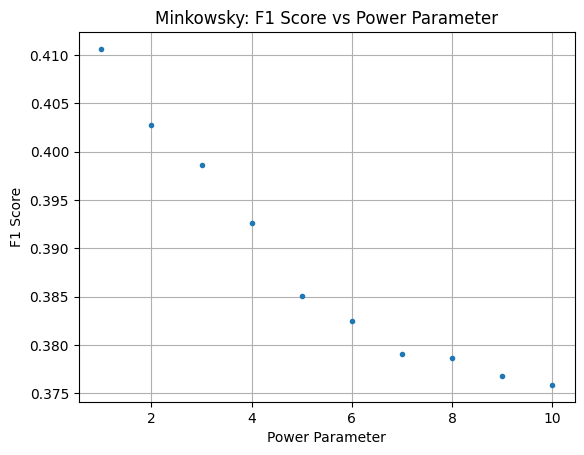

Minkowski distance F1 score: 0.4106213603214811
Cosine distance F1 score: 0.395503223526041
Chebyshev distance F1 score: 0.3547833305180646


In [4]:
# Things to tune:
# distance metric
# standardize vs scale: STANDARDIZE
# p in minkowsky distance
# k in k-nearest neighbors: k = sqrt(n)
# weighted vs standard k-nearest neighbors algorithm: WEIGHTED

# Tune minkowski distance
weights = get_weights(y_train)
p_values = np.arange(1, 11, 1)
k = get_k_value(X_train_standardized)
k_values = [k]
best_p_minkowski, best_k_minkowski = tune_minkowski(X_train_standardized, y_train, weights, 10, p_values, k_values, weighted=True)
# Tune cosine distance
#k_values = np.arange(1, 301, 24)
#best_k_cosine = tune_other_distance(X_train_standardized, y_train, weights, 10, k_values, get_cosine_distance, weighted=True)
# Tune chebyshev distance
#best_k_chebyshev = tune_other_distance(X_train_standardized, y_train, weights, 10, k_values, get_chebyshev_distance, weighted=True)

# Evaluate minkowski distance model
minkowski_score = cross_validation(X_train_standardized, y_train, k, weights, get_minkowski_distance, 10, weighted=True, p_minkowski=best_p_minkowski)
# Evaluate cosine distance model
cosine_score = cross_validation(X_train_standardized, y_train, k, weights, get_cosine_distance, 10, weighted=True)
# Evaluate chebyshev distance model
chebyshev_score = cross_validation(X_train_standardized, y_train, k, weights, get_chebyshev_distance, 10, weighted=True)
# Print the results
print(f"Minkowski distance F1 score: {minkowski_score}\n"
      f"Cosine distance F1 score: {cosine_score}\n"
      f"Chebyshev distance F1 score: {chebyshev_score}")

## Final Model and Results

In [5]:
# Get weights and k value
weights = get_weights(y_test)
k = get_k_value(X_test_standardized)
# Make predictions
trained_predictions = predict_from_same_set(X_test_standardized, y_test, k, weights, get_minkowski_distance, weighted=True, p_minkowski=best_p_minkowski)
# Evaluate results
trained_accuracy = get_accuracy(y_test, trained_predictions)
trained_confusion_matrix = get_confusion_matrix(y_test, trained_predictions)
trained_f1_score = get_f1_score(y_test, trained_predictions)
TN, FP, FN, TP = get_confusion_matrix(y_test, trained_predictions).ravel()
print(
    f"Accuracy: {trained_accuracy}\n"
    f"F1-score: {trained_f1_score}\n"
    f"TN, FP, TP, FN: {TN}, {FP}, {TP}, {FN}\n"
)

Point: 0

Point: 100

Point: 200

Point: 300

Point: 400

Point: 500

Point: 600

Point: 700

Point: 800

Point: 900

Point: 1000

Point: 1100

Point: 1200

Point: 1300

Point: 1400

Point: 1500

Point: 1600

Point: 1700

Point: 1800

Point: 1900

Point: 2000

Point: 2100

Point: 2200

Point: 2300

Point: 2400

Point: 2500

Point: 2600

Point: 2700

Point: 2800

Point: 2900

Point: 3000

Point: 3100

Point: 3200

Point: 3300

Point: 3400

Point: 3500

Point: 3600

Point: 3700

Point: 3800

Point: 3900

Point: 4000

Point: 4100

Point: 4200

Point: 4300

Point: 4400

Point: 4500

Point: 4600

Point: 4700

Point: 4800

Point: 4900

Point: 5000

Point: 5100

Point: 5200

Point: 5300

Point: 5400

Point: 5500

Point: 5600

Point: 5700

Point: 5800

Point: 5900

Point: 6000

Point: 6100

Point: 6200

Point: 6300

Point: 6400

Point: 6500

Point: 6600

Point: 6700

Point: 6800

Point: 6900

Point: 7000

Point: 7100

Point: 7200

Point: 7300

Point: 7400

Point: 7500

Point: 7600

Point: 7700